In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark

In [2]:
bank = pd.read_csv(r"C:\Users\Ngoc Minh\Downloads\python course\cleaned_data.csv")

🔍 Vấn đề đang được giải quyết:
__Một ngân hàng tại Bồ Đào Nha__ đang chuẩn bị tung ra __sản phẩm tiền gửi có kỳ hạn (term deposit)__ và muốn tìm cách __liên hệ đúng người, đúng nhu cầu__. Trong quá khứ, họ đã gọi điện cho hàng loạt khách hàng và có lưu lại kết quả xem ai đã đăng ký sản phẩm sau cuộc gọi, ai thì không.

Tuy nhiên, hiện tại có 2 vấn đề lớn:

__1. Khách hàng than phiền__: Họ bị gọi làm phiền vì những sản phẩm họ không quan tâm → ảnh hưởng hình ảnh ngân hàng.

__2. Không có hệ thống lựa chọn khách hàng tiềm năng__: Hiện tại nhân viên chọn khách hàng một cách thủ công, không hiệu quả.

✅ Mục tiêu dự án:
__Xây dựng một mô hình học máy (machine learning model)__ dựa trên dữ liệu lịch sử, để dự đoán xem __khách hàng nào nên được gọi điện (có khả năng cao sẽ đăng ký tiền gửi kỳ hạn)__ và __khách nào nên bỏ qua__.

Kết quả mong muốn:
– Mô hình sẽ đưa ra dự đoán "yes"/"no" cho từng khách hàng trong dữ liệu test: <br>
→ __"yes"__ nghĩa là __nên gọi, có thể họ sẽ mua sản phẩm__ <br>
→ __"no"__ nghĩa là __không nên gọi, tránh làm phiền__

__Thông tin về khách hàng ngân hàng__

- **`age`**: Tuổi
- **`job`**: Loại công việc
- **`marital`**: Tình trạng hôn nhân  
  *(Lưu ý: `"divorced"` bao gồm cả ly hôn và góa)*
- **`education`**: Trình độ học vấn
- **`default`**: Có từng không trả được khoản vay nào trước đây không?
- **`balance`**: Số dư trung bình hàng năm (euro)
- **`housing`**: Có vay thế chấp không?
- **`loan`**: Có khoản vay tín chấp không?


__Liên quan đến lần liên lạc cuối cùng với khách hàng trong chiến dịch hiện tại__

- **`contact`**: Loại hình liên lạc trong lần cuối cùng
- **`day`**: Ngày của lần liên lạc cuối cùng
- **`month`**: Tháng của lần liên lạc cuối cùng
- **`duration`**: Thời lượng cuộc gọi cuối cùng (tính bằng giây)

---

__Các thuộc tính khác__

- **`campaign`**: Số lần liên hệ trong chiến dịch hiện tại (bao gồm cả lần cuối)
- **`pdays`**: Số ngày kể từ lần cuối được liên hệ trong chiến dịch trước  
  *(Giá trị -1 nghĩa là chưa từng được liên hệ)*
- **`previous`**: Số lần liên hệ trước đây trong các chiến dịch trước đó
- **`poutcome`**: Kết quả của chiến dịch marketing trước

---

__Biến mục tiêu (target)__

- **`y`**: Khách hàng có đăng ký gửi tiết kiệm kỳ hạn hay không?

In [3]:
bank.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,-1,0,0,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,-1,0,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,-1,0,0,no
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,-1,0,0,no
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,may,198,1,-1,0,0,no
5,35,management,married,tertiary,no,231,yes,no,cellular,5,may,139,1,-1,0,0,no
6,28,management,single,tertiary,no,447,yes,yes,cellular,5,may,217,1,-1,0,0,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,cellular,5,may,380,1,-1,0,0,no
8,58,retired,married,primary,no,121,yes,no,cellular,5,may,50,1,-1,0,0,no
9,43,technician,single,secondary,no,593,yes,no,cellular,5,may,55,1,-1,0,0,no


#### Feature Engineering

tạo bin cho balance

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col

# Khởi tạo session nếu chưa có
spark = SparkSession.builder.appName("FeatureBalance").getOrCreate()

# Load data nếu cần
bank = spark.read.csv(r"C:\Users\Ngoc Minh\Downloads\python course\cleaned_data.csv", header=True, inferSchema=True)

# Cast balance nếu cần
bank = bank.withColumn("balance", col("balance").cast("double"))

# Tạo biểu thức phân loại balance
balance_bin_expr = when(col("balance") <= 0, "≤ 0") \
    .when((col("balance") > 0) & (col("balance") <= 500), "0-500") \
    .when((col("balance") > 500) & (col("balance") <= 1500), "500-1500") \
    .when((col("balance") > 1500) & (col("balance") <= 3000), "1500-3000") \
    .when((col("balance") > 3000) & (col("balance") <= 10000), "3000-10000") \
    .otherwise(">10000")

# Thêm cột mới
bank = bank.withColumn("balance_bin", balance_bin_expr)


tạo bin thành age group

In [5]:
age_group_expr = when(col("age") <= 25, "<25") \
    .when((col("age") > 25) & (col("age") <= 35), "25-35") \
    .when((col("age") > 35) & (col("age") <= 45), "35-45") \
    .when((col("age") > 45) & (col("age") <= 60), "45-60") \
    .otherwise(">60")

bank = bank.withColumn("age_group", age_group_expr)

tạo bin cho biến duration

In [6]:
duration_bin_expr = when(col("duration") <= 100, "(0-100]") \
    .when((col("duration") > 100) & (col("duration") <= 200), "(100-200]") \
    .when((col("duration") > 200) & (col("duration") <= 300), "(200-300]") \
    .when((col("duration") > 300) & (col("duration") <= 400), "(300-400]") \
    .when((col("duration") > 400) & (col("duration") <= 500), "(400-500]") \
    .otherwise("(500+)")
    
bank = bank.withColumn("duration_bin", duration_bin_expr)


tạo biến contact history

In [7]:
bank = bank.withColumn(
    "contact_history",
    when(col("previous") == 0, "new").otherwise("contacted_before")
)

tạo biến financial burnden từ yes (housing) & yes (loan)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col

# Khởi tạo SparkSession
spark = SparkSession.builder.appName("FinancialBurdenFeature").getOrCreate()

# Tạo cột mới 'financial_burden'
bank = bank.withColumn(
    "financial_burden",
    when((col("housing") == "yes") & (col("loan") == "yes"), "both")
    .when((col("housing") == "yes") | (col("loan") == "yes"), "only one")
    .otherwise("none")
)

tạo golden group

In [9]:
from pyspark.sql.functions import when, col

# Bước 1: Tính median balance bằng approxQuantile
median_balance = bank.approxQuantile("balance", [0.5], 0.01)[0]

# Bước 2: Gán nhóm 'golden' nếu balance cao & không có khoản vay nào
bank = bank.withColumn(
    "golden_group",
    when((col("balance") > median_balance) & (col("financial_burden") == "none"), "golden")
    .otherwise("other")
)

tạo bin cho pdays

In [10]:
from pyspark.sql.functions import when, col

# Bước 1: Lọc các dòng có pdays ≠ -1
bank = bank.filter(col("pdays") != -1)

# Bước 2: Tạo cột phân loại pdays_range bằng when()
bank = bank.withColumn(
    "pdays_range",
    when((col("pdays") >= 0) & (col("pdays") <= 7), "<1 week")
    .when((col("pdays") > 7) & (col("pdays") <= 14), "1–2 weeks")
    .when((col("pdays") > 14) & (col("pdays") <= 30), "2–4 weeks")
    .when((col("pdays") > 30) & (col("pdays") <= 90), "1–3 months")
    .otherwise(">3 months")
)

In [11]:
bank.show(10)

+---+-----------+-------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+-----------+---------+------------+----------------+----------------+------------+-----------+
|age|        job|marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|  y|balance_bin|age_group|duration_bin| contact_history|financial_burden|golden_group|pdays_range|
+---+-----------+-------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+-----------+---------+------------+----------------+----------------+------------+-----------+
| 33|     admin.|married| tertiary|     no|  882.0|     no|  no|telephone| 21|  oct|      39|       1|  151|       3|       0| no|   500-1500|    25-35|     (0-100]|contacted_before|            none|      golden|  >3 months|
| 42|     admin.| single|secondary|     no| -247.0|    yes| yes|telephone| 21|  oct|     519|       

chuyển dữ liệu về thư viện pandas sau khi feature engineering

In [12]:
bank = bank.toPandas()

bây giờ sẽ dùng pandas và matplotlib để EDA và visualization

#### I. HÀNH VI KHÁCH HÀNG – CUSTOMER BEHAVIOR

__1. Tỷ lệ khách hàng đăng ký sản phẩm (y) là bao nhiêu?__ <br>
 → Tỷ lệ success vs fail để hiểu mức độ "khó" của chiến dịch.

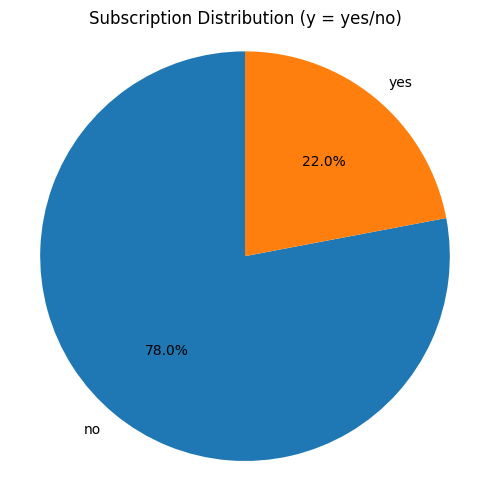

In [13]:
# Bước 1: Lấy tỷ lệ phần trăm từng giá trị
y_percent = bank['y'].value_counts(normalize=True) * 100

# Bước 2: Vẽ biểu đồ tròn
plt.figure(figsize=(5,5))
plt.pie(y_percent, labels=y_percent.index, autopct='%1.1f%%', startangle=90)
plt.title("Subscription Distribution (y = yes/no)")
plt.axis('equal')  # Giữ hình tròn đều
plt.tight_layout()
plt.show()

__3. Sự khác biệt trong tỷ lệ đăng ký theo tình trạng hôn nhân (marital)?__

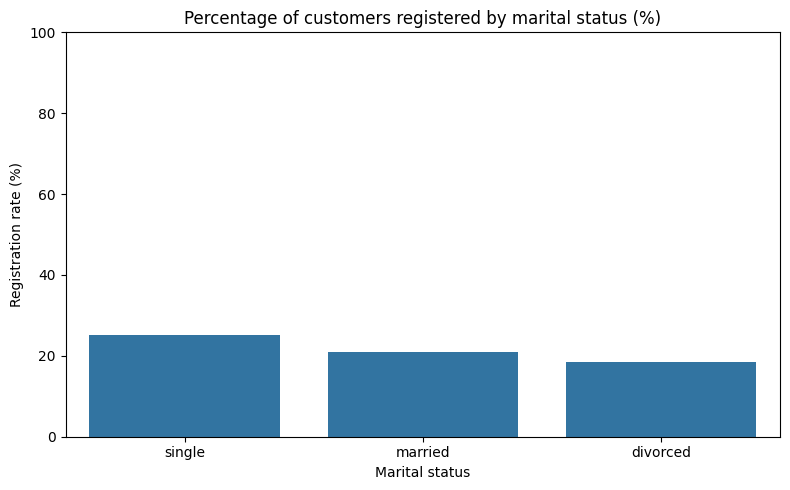

In [ ]:
# Tổng số khách hàng theo marital status
marital_total = bank['marital'].value_counts()

# Số lượng khách hàng đăng ký (y = 'yes') theo marital status
marital_yes = bank[bank['y'] == 'yes']['marital'].value_counts()

# Tính tỷ lệ đăng ký
marital_rate = (marital_yes / marital_total * 100).sort_values(ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(8,5))
sns.barplot(x=marital_rate.index, y=marital_rate.values)
plt.title("Percentage of customers registered by marital status (%)")
plt.xlabel("Marital status")
plt.ylabel("Registration rate (%)")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

In [35]:
print(marital_rate)

marital
single      25.127986
married     21.035599
divorced    18.439716
Name: count, dtype: float64


Nhóm người độc thân không có gánh nặng tài chính sẽ có tỷ lệ đăng ký nhỉnh hơn một chút so với "married" và "divorced"

__1. Những khách hàng có tài khoản ngân hàng với số dư cao (balance) có xu hướng đăng ký sản phẩm không?__

C:\Users\Ngoc Minh\AppData\Local\Temp\ipykernel_13792\1116506880.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=balance_bin_rate, x="balance_bin", y="yes", palette="Blues_d", ax=axes[0])


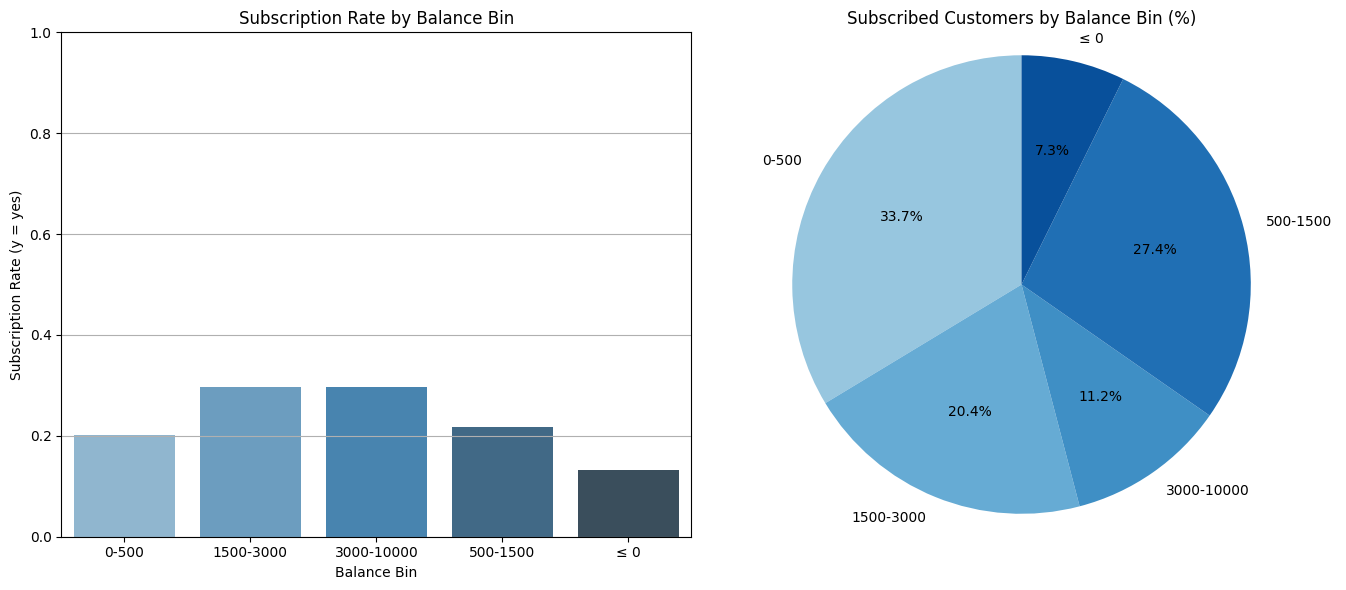

In [15]:
# --- Barplot: Tỷ lệ y=yes theo balance_bin ---
balance_bin_rate = bank.groupby("balance_bin")["y"].value_counts(normalize=True).unstack().fillna(0).reset_index()

# --- Pie chart: Phân bố số lượng khách đăng ký theo balance_bin ---
bank_yes = bank[bank['y'] == 'yes']
bin_counts = bank_yes['balance_bin'].value_counts().sort_index()

# --- Tạo figure gồm 2 subplot ngang ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Biểu đồ 1: barplot
sns.barplot(data=balance_bin_rate, x="balance_bin", y="yes", palette="Blues_d", ax=axes[0])
axes[0].set_title("Subscription Rate by Balance Bin")
axes[0].set_xlabel("Balance Bin")
axes[0].set_ylabel("Subscription Rate (y = yes)")
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x')
axes[0].grid(axis="y")

# Biểu đồ 2: pie chart
colors = plt.cm.Blues(range(100, 256, int(155 / len(bin_counts))))
axes[1].pie(bin_counts, labels=bin_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title("Subscribed Customers by Balance Bin (%)")
axes[1].axis('equal')

# Hiển thị cả 2 biểu đồ
plt.tight_layout()
plt.show()


In [29]:
print(balance_bin_rate)

y balance_bin        no       yes
0       0-500  0.797455  0.202545
1   1500-3000  0.703248  0.296752
2  3000-10000  0.703822  0.296178
3    500-1500  0.783254  0.216746
4         ≤ 0  0.866887  0.133113


Nhóm có balance cao có tỷ lệ đăng ký cao hơn do họ có một nền tảng tài chính mạnh để mua thêm những sản phẩm tài hcinhs mới. Tuy nhiên, nhóm có balance âm hoặc thấp vẫn đăng ký, cho thấy đây không phải là yếu tố quyết định tới nhu cầu về sản phẩm, tuy nhiên, nên có một kế hoạch tiếp thị và bán sản phẩm phù hợp cho từng nhóm.

__2. Sự kết hợp giữa thu nhập (balance) và nợ hiện tại (loan, housing) có ảnh hưởng đến quyết định đăng ký?__

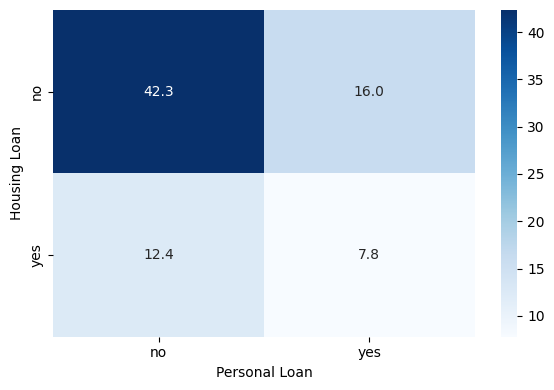

In [43]:
# Bước 1: Tính balance trung bình và tỷ lệ đăng ký theo housing & loan
df_agg = bank.groupby(["housing", "loan"]).agg(
    avg_balance=("balance", "mean"),
    pct_yes=("y", lambda x: (x == "yes").mean() * 100)
).reset_index()


# Bước 2: Pivot để chuẩn bị dữ liệu cho heatmap
heatmap_data = df_agg.pivot(index="housing", columns="loan", values="pct_yes")

# Bước 3: Vẽ heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="Blues")

# plt.title("Subscription Rate (%) by Loan and Housing Status")
plt.xlabel("Personal Loan")
plt.ylabel("Housing Loan")
plt.tight_layout()
plt.show()

In [33]:
print(df_agg)

  housing loan  avg_balance    pct_yes
0      no   no  1211.662814  42.327621
1      no  yes   734.548507  16.044776
2     yes   no   895.856708  12.376363
3     yes  yes   684.454774   7.788945


Những người có khoản vay thế chấp và khoản vay cá nhân có tỷ lệ đăng ký thấp hơn do họ đã có nghĩa vụ tài hcinhs phải trả vì vậy gánh nặng tài chính hiện tại khiến họ ít sẵn sàng để mua thêm sản phẩm mới.

__1. Kết hợp job và education để tìm nhóm nghề có trình độ cao và tỷ lệ đăng ký cao nhất. Đây có thể là “chân dung vàng” của khách hàng mục tiêu.__

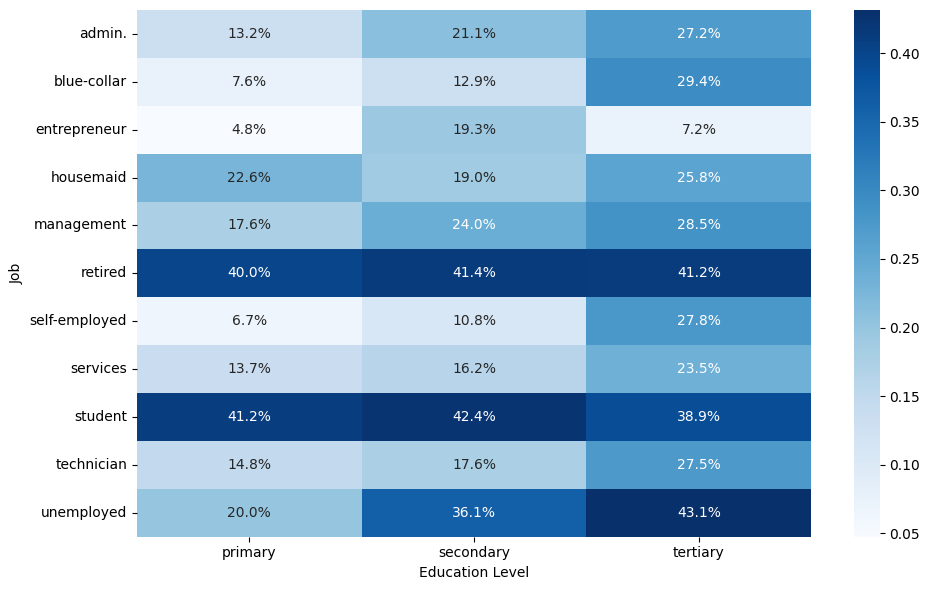

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Tính tỷ lệ đăng ký theo job + education
pivot_data = bank.groupby(["job", "education"])["y"].value_counts(normalize=True).unstack().fillna(0).reset_index()

# Pivot để tạo heatmap
heatmap_data = pivot_data.pivot(index="job", columns="education", values="yes")

# Vẽ heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1%", cmap="Blues")
# plt.title("Subscription Rate by Job and Education")
plt.xlabel("Education Level")
plt.ylabel("Job")
plt.tight_layout()
plt.show()

Những người với trình độ học vấn cao, có tỷ lệ đăng ký cao hơn so với trình độ primary và secondary.
Những người làm trong các ngành chuyên môn, liên quan nhiều đến lao động trí óc như admin, entrepreneur cũng là nhóm khách hàng nên được chú trọng.
=> Vì họ là những khách hàng hiểu được thị trường và sản phẩm, có tài chính ổn định và dễ tiếp cận

=> Khuyến nghị: Tập trung chiến lược tiếp thị vào các nhóm có hiệu suất cao và tìm cách cải thiện chuyển đổi trong các nhóm có hiệu suất kém.

__3. Những người balance cao + housing == no + loan == no thì có phải là nhóm “dễ chốt” nhất?__

golden group là nhóm khong vay nhà, vay cá nhân và có số dư trên median của balance

C:\Users\Ngoc Minh\AppData\Local\Temp\ipykernel_13792\1354493928.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_rate, x="golden_group", y="yes", palette="Blues")


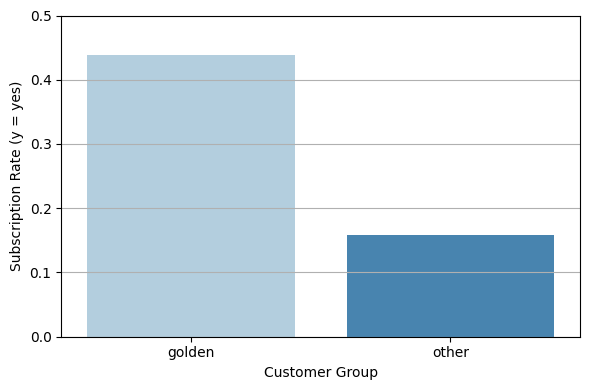

In [46]:
# Tính tỷ lệ đăng ký
group_rate = bank.groupby("golden_group")["y"].value_counts(normalize=True).unstack().fillna(0).reset_index()

# Vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.barplot(data=group_rate, x="golden_group", y="yes", palette="Blues")
# plt.title("Subscription Rate: Golden Group vs Others")
plt.ylabel("Subscription Rate (y = yes)")
plt.xlabel("Customer Group")
plt.ylim(0, 0.5)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [47]:
print(group_rate)

y golden_group        no       yes
0       golden  0.561212  0.438788
1        other  0.841289  0.158711


Đây là nhóm có nguồn tiền dồi dào, không bị ràng buộc tài chính do có nguồn tài chính dồi dào và khả năng đầu tư cao hơn.
Vì là nhóm có tỷ lệ chuyển đổi cao nhất nên cần phải có kế hoạch tiếp cận và ưu tiên tập trung nhóm khách hàng trên.

#### II. HIỆU SUẤT CHIẾN DỊCH MARKETING – CAMPAIGN PERFORMANCE

__1. Có phải gọi quá nhiều lần thì tỷ lệ đăng ký lại giảm (spam effect)?__

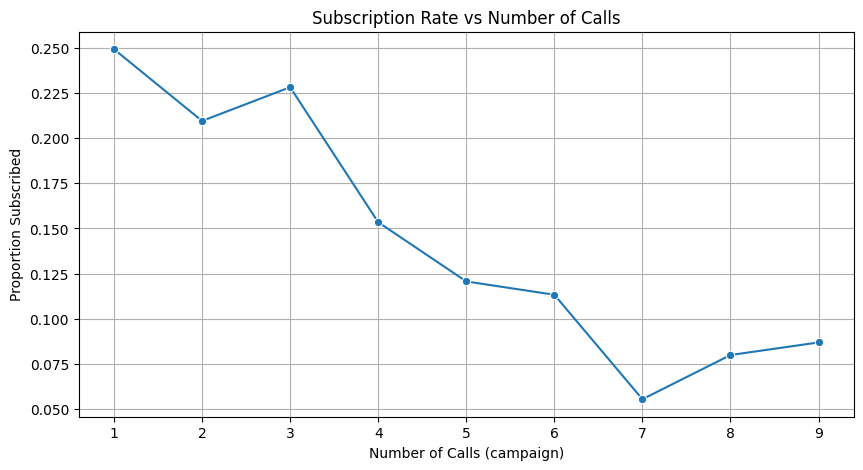

In [ ]:
# Tính tỷ lệ đăng ký theo số lần gọi
campaign_ratio = bank.groupby('campaign')['y'].value_counts(normalize=True).unstack().fillna(0)
campaign_ratio = campaign_ratio.reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=campaign_ratio, x='campaign', y='yes', marker='o')
# plt.title("Subscription Rate vs Number of Calls")
plt.xlabel("Number of Calls (campaign)")
plt.ylabel("Proportion Subscribed")
plt.grid(True)
plt.show()

In [48]:
print(campaign_ratio)

y  campaign        no       yes
0         1  0.750885  0.249115
1         2  0.790553  0.209447
2         3  0.771887  0.228113
3         4  0.846547  0.153453
4         5  0.879310  0.120690
5         6  0.886667  0.113333
6         7  0.944444  0.055556
7         8  0.920000  0.080000
8         9  0.913043  0.086957


Gọi quá nhiều lần không giúp tăng tỷ lệ đăng ký mà ngược lại có xu hướng làm giảm do khách hàng có thể coi đây là cuộc gọi lừa đảo và tránh việc nghe điện. Điều này cho thấy hiệ ứng spam mang lại hiệu quả khá tiêu cực.

=> Vì vậy ***số lần gọi tối ưu*** là 1-2 lần.

__3. Thời lượng cuộc gọi (duration) có liên quan thế nào đến khả năng đăng ký? Có mức tối thiểu cần đạt?__

In [20]:
duration_rate = bank.groupby('duration_bin')['y'].value_counts(normalize=True).unstack().fillna(0)
duration_rate = duration_rate.reset_index()

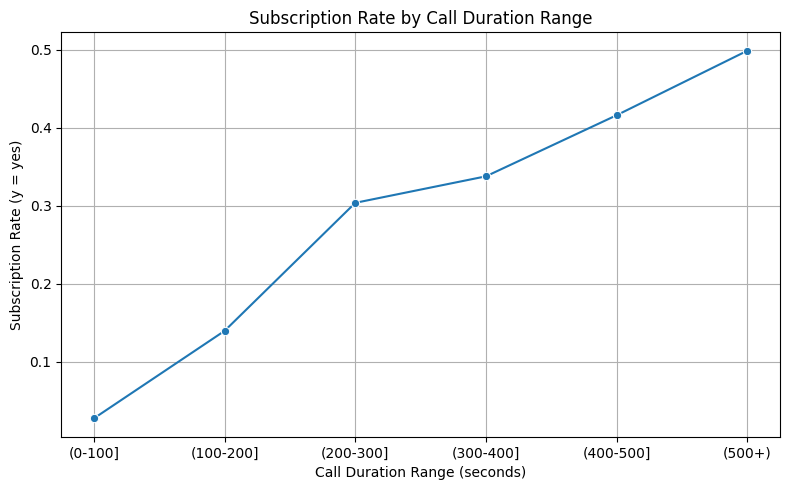

In [21]:
# Chuyển duration_bin thành chuỗi để vẽ được trục x
duration_rate["duration_bin"] = duration_rate["duration_bin"].astype(str)

# Vẽ lại
plt.figure(figsize=(8,5))
sns.lineplot(data=duration_rate, x="duration_bin", y="yes", marker='o')
plt.title("Subscription Rate by Call Duration Range")
plt.xlabel("Call Duration Range (seconds)")
plt.ylabel("Subscription Rate (y = yes)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
print(duration_rate)

y duration_bin        no       yes
0      (0-100]  0.972308  0.027692
1    (100-200]  0.860242  0.139758
2    (200-300]  0.696286  0.303714
3    (300-400]  0.662322  0.337678
4    (400-500]  0.584071  0.415929
5       (500+)  0.501449  0.498551


- Thời lượng gọi càng dài, tỷ lệ đăng ký càng cao cho thấy người mua sản phẩm có hứng thú với sản phẩm và sẵn sàng nghe giới thiệu về sản phẩm.

=> Cần tăng chất lượng cuộc gọi để cung cấp được luongj wthoong tin nhiều nhất về sản phẩm và có khả năng thu hút khách hàng.

__4. Kênh gọi (contact: telephone vs cellular) ảnh hưởng ra sao đến tỷ lệ thành công? Kênh nào hiệu quả hơn với từng nhóm người?__

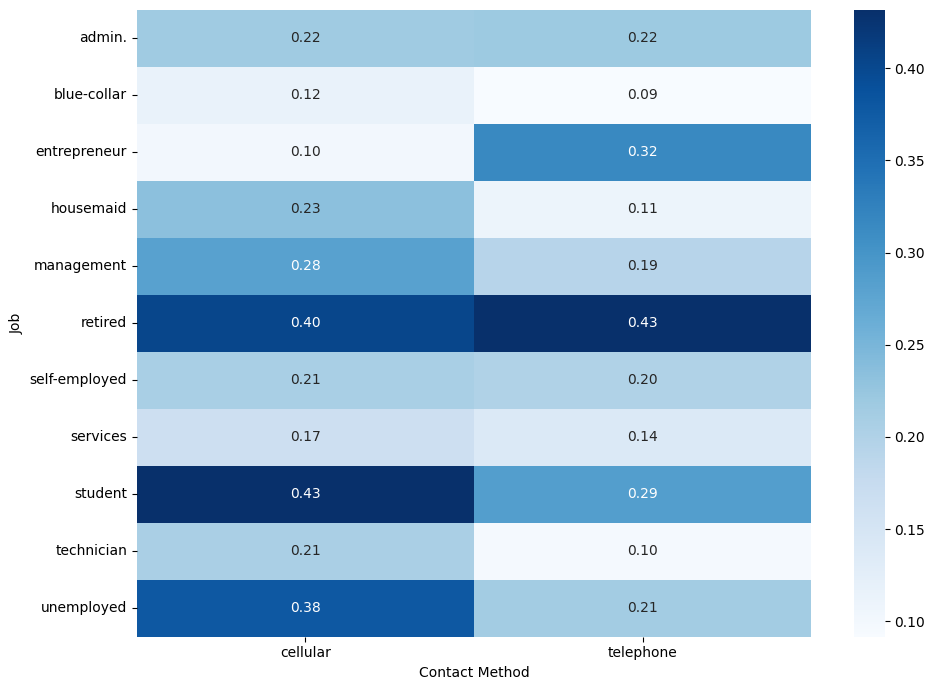

In [ ]:
# Tính tỷ lệ đăng ký theo job + contact
heat_df = bank.groupby(["job", "contact"])["y"].apply(lambda x: (x == "yes").mean()).reset_index(name="subscription_rate")

# Pivot để tạo bảng heatmap
pivot_heat = heat_df.pivot(index="job", columns="contact", values="subscription_rate").fillna(0)

# Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(pivot_heat, annot=True, fmt=".2f", cmap="Blues")

# plt.title("Subscription Rate by Contact Method and Job")
plt.xlabel("Contact Method")
plt.ylabel("Job")
plt.tight_layout()
plt.show()


Cellular hiệu quả hơn so với Telephone do việc dùng điện thoại bàn ngày nay đã giảm hẳn. Việc gọi vào cellular phone giúp ngân hàng dễ tiếp cận khách hàng hơn.

__1. Khách hàng đã từng được liên hệ trong quá khứ (previous) thì khả năng đăng ký lần này cao hơn không?__

contact_history: chưa từng contact "new" khi biến previous bằng 0, otherwise đều là contacted_before

In [23]:
history_rate = bank.groupby("contact_history")["y"].value_counts(normalize=True).unstack().fillna(0).reset_index()

In [60]:
print(history_rate)

    contact_history        no       yes
0  contacted_before  0.779803  0.220197


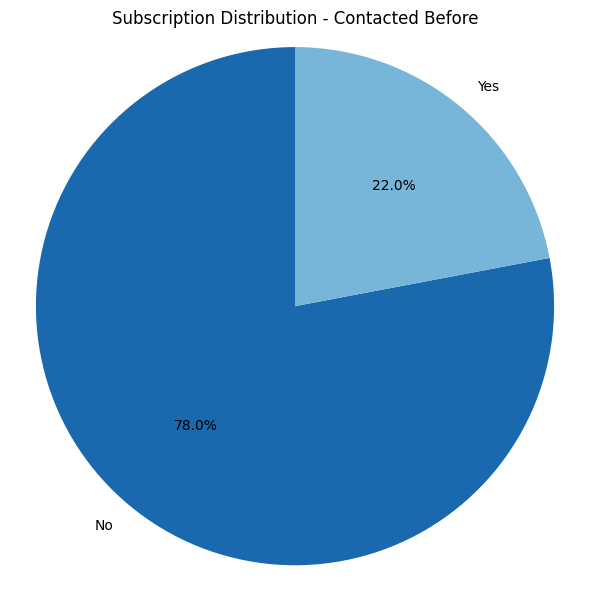

In [ ]:
# Tạo bảng lại từ tay
history_rate = pd.DataFrame({
    "contact_history": ["contacted_before"],
    "no": [0.779803],
    "yes": [0.220197]
})

# Dữ liệu để vẽ pie chart
labels = ["No", "Yes"]
sizes = [history_rate.loc[0, "no"], history_rate.loc[0, "yes"]]

# Vẽ pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, colors=plt.cm.Blues([200, 120]))
plt.title("Subscription Distribution - Contacted Before")
plt.axis('equal')
plt.tight_layout()
plt.show()

Biểu đồ cho thấy những khách hàng đã từng được liên hệ trong quá khứ có tỷ lệ đăng kí cao hơn so với những chưa từng được liên hệ. Điều này cho thấy việc chăm sóc khách hàng hay cụ thể là telesale có thể mang lại hiệu quả đáng kể, giúp tăng khả năng đăng ký của khách hàng.

__2. Nếu lần gọi trước đã thành công (poutcome == success) thì tỷ lệ thành công lần này thế nào?__

In [ ]:
poutcome_rate = bank.groupby("poutcome")["y"].value_counts(normalize=True).unstack().fillna(0).reset_index()

In [59]:
print(poutcome_rate)

y  poutcome        no       yes
0         0  0.872848  0.127152
1         1  0.357879  0.642121


y  poutcome        no       yes
0.127152
0.642121

C:\Users\Ngoc Minh\AppData\Local\Temp\ipykernel_13792\235878428.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_data, x="poutcome", y="yes", palette="Blues")


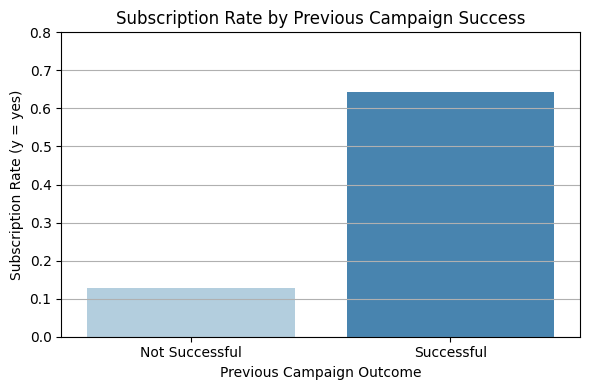

In [26]:
# Tạo bản sao để không ảnh hưởng gốc
plot_data = poutcome_rate.copy()

# Vẽ biểu đồ
plt.figure(figsize=(6, 4))
sns.barplot(data=plot_data, x="poutcome", y="yes", palette="Blues")

# Đổi nhãn trực tiếp trên trục
plt.xticks(ticks=[0, 1], labels=["Not Successful", "Successful"])

plt.title("Subscription Rate by Previous Campaign Success")
plt.xlabel("Previous Campaign Outcome")
plt.ylabel("Subscription Rate (y = yes)")
plt.ylim(0, 0.8)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


Tỷ lệ khách hàng đã thành công trong chiến dịch trước có tỷ lệ đăng ký rất cao trong lần này do họ đã có sự tin tưởng nhất định vào sản phẩm. Vì vậy đây là nhóm khách hàng rất tiềm năng, nên được ưu tiên trong các chiến dịch mới, càn chú trọng khâu chăm sóc khách hàng để duy trì mối quan hệ và bán thêm sản phẩm.

__3. Sau bao nhiêu ngày kể từ chiến dịch trước (pdays) thì nên gọi lại? Gọi lại quá nhanh hoặc quá chậm có gây phản cảm?__

In [53]:
pdays_rate = bank.groupby("pdays_range")["y"].value_counts(normalize=True).unstack().fillna(0).reset_index()

In [58]:
print(pdays_rate)

y pdays_range        no       yes
0   1–2 weeks  0.852459  0.147541
1  1–3 months  0.570499  0.429501
2   2–4 weeks  0.810811  0.189189
3     <1 week  0.876543  0.123457
4   >3 months  0.791885  0.208115


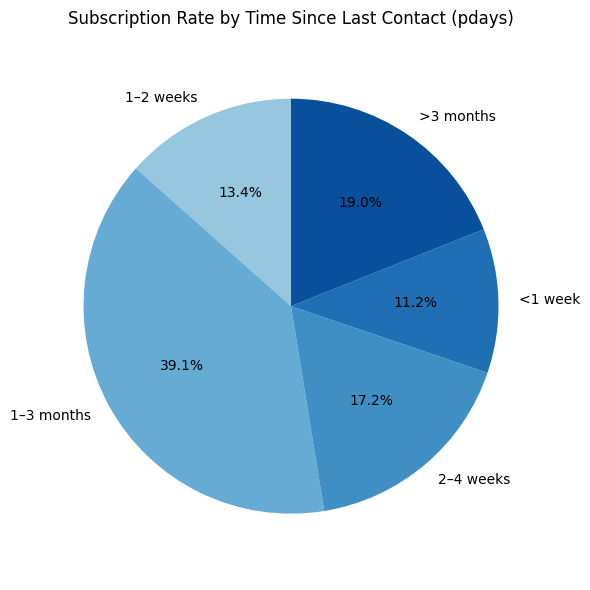

In [57]:
import matplotlib.pyplot as plt

# Lấy nhãn và giá trị tỷ lệ đăng ký (y = yes) theo nhóm pdays
labels = pdays_rate["pdays_range"]
sizes = pdays_rate["yes"]

# Vẽ pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Blues(range(100, 256, int(155/len(labels)))))
plt.title("Subscription Rate by Time Since Last Contact (pdays)")
plt.axis('equal')  # Giữ hình tròn
plt.tight_layout()
plt.show()


* Khách hàng có xu hướng đăng ký cao nhất khi được liên hệ lại sau 1–3 tháng.
* Liên hệ quá sớm (<1 tuần) hoặc quá muộn (>3 tháng) cho thấy tỷ lệ đăng ký thấp hơn.